# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

import tensorflow_data_validation as tfdv
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, average_precision_score, fbeta_score, f1_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve

Error importing tfx_bsl_extension.arrow.array_util. Some tfx_bsl functionalities are not availableError importing tfx_bsl_extension.arrow.table_util. Some tfx_bsl functionalities are not availableError importing tfx_bsl_extension.arrow.table_util. Some tfx_bsl functionalities are not available

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response:??

In [4]:
len(df), df.patient_nbr.nunique(), df.encounter_id.nunique()

(143424, 71518, 101766)

### Dataset is line level (more rows than unique encounter_ids)

In [5]:
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  \
0                 1          ?  Pediatrics-Endocrinology   
1                 3          ?                         ?   
2                 2          ?                         ?   
3                 2          ?                         ?   
4                 1          ?                         ?   

  primary_diagnosis_code other_diagnosis_codes  number_outpatient  \
0                 250.83                   ?|?                  0   
1                    276            250.01|255                  0   
2                    648               250|V27                  2   
3                      8            250.43|403                  0   
4                    197               157|250                  0   

   number_inpatient  number_emergency  num_lab_procedures  number_diagnoses  \
0                 0                 0                  41                 1   
1                 0                 0                  59                 9   
2                 1                 0                  11                 6   
3                 0                 0                  44                 7   
4                 0                 0                  51                 5   

   num_medications  num_procedures    ndc_code max_glu_serum A1Cresult change  \
0                1               0         NaN          None      None     No   
1               18               0  68071-1701          None      None     Ch   
2               13               5   0378-1110          None      None     No   
3               16               1  68071-1701          None      None     Ch   
4                8               0   0049-4110          None      None     Ch   

  readmitted  
0         NO  
1        >30  
2         NO  
3         NO  
4         NO

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: ??

### Reviewer Feedback: You have treated 'None' for max_glu_serum and A1Cresult as a missing value. However, this is not true. If we refer to the codebook, we will find that 'None' for these columns means that the values were not measured. It is important information in this case. This might happen if the patient was not too sick and did not require a lab test for these values. So, you should not consider 'None' as missing value for these two columns. Also, IMO, we can work with medical_specialty and payer_code columns too as they have less than 50% missing value. The missing values for these categorical features can be imputed.

In [6]:
# Replace missing max_glu_serum and A1Cresult values with "Norm"
df[['max_glu_serum', 'A1Cresult']] = df[['max_glu_serum', 'A1Cresult']].replace(np.nan, 'Norm').replace('None', 'Norm')
# Replace missing values with np.nan
df = df.replace('?', np.nan).replace('None', np.nan)
df = df.replace('nan', np.nan)
# Fields with missing/zero values
df.isnull().mean().sort_values(ascending=True)

encounter_id                0.000000
A1Cresult                   0.000000
max_glu_serum               0.000000
num_procedures              0.000000
num_medications             0.000000
number_diagnoses            0.000000
num_lab_procedures          0.000000
number_emergency            0.000000
number_inpatient            0.000000
number_outpatient           0.000000
other_diagnosis_codes       0.000000
change                      0.000000
readmitted                  0.000000
time_in_hospital            0.000000
admission_source_id         0.000000
discharge_disposition_id    0.000000
admission_type_id           0.000000
age                         0.000000
gender                      0.000000
patient_nbr                 0.000000
primary_diagnosis_code      0.000230
race                        0.023071
ndc_code                    0.163585
payer_code                  0.377831
medical_specialty           0.484319
weight                      0.970005
dtype: float64

### Weight is the only field with higher than 50% missing values and will therefore be dropped. The other fields with missing values can be imputed.

In [7]:
df = df.drop(['weight'], axis=1)

In [8]:
# histograms of numerical values
df.select_dtypes(['int64']).columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'number_outpatient', 'number_inpatient', 'number_emergency',
       'num_lab_procedures', 'number_diagnoses', 'num_medications',
       'num_procedures'],
      dtype='object')

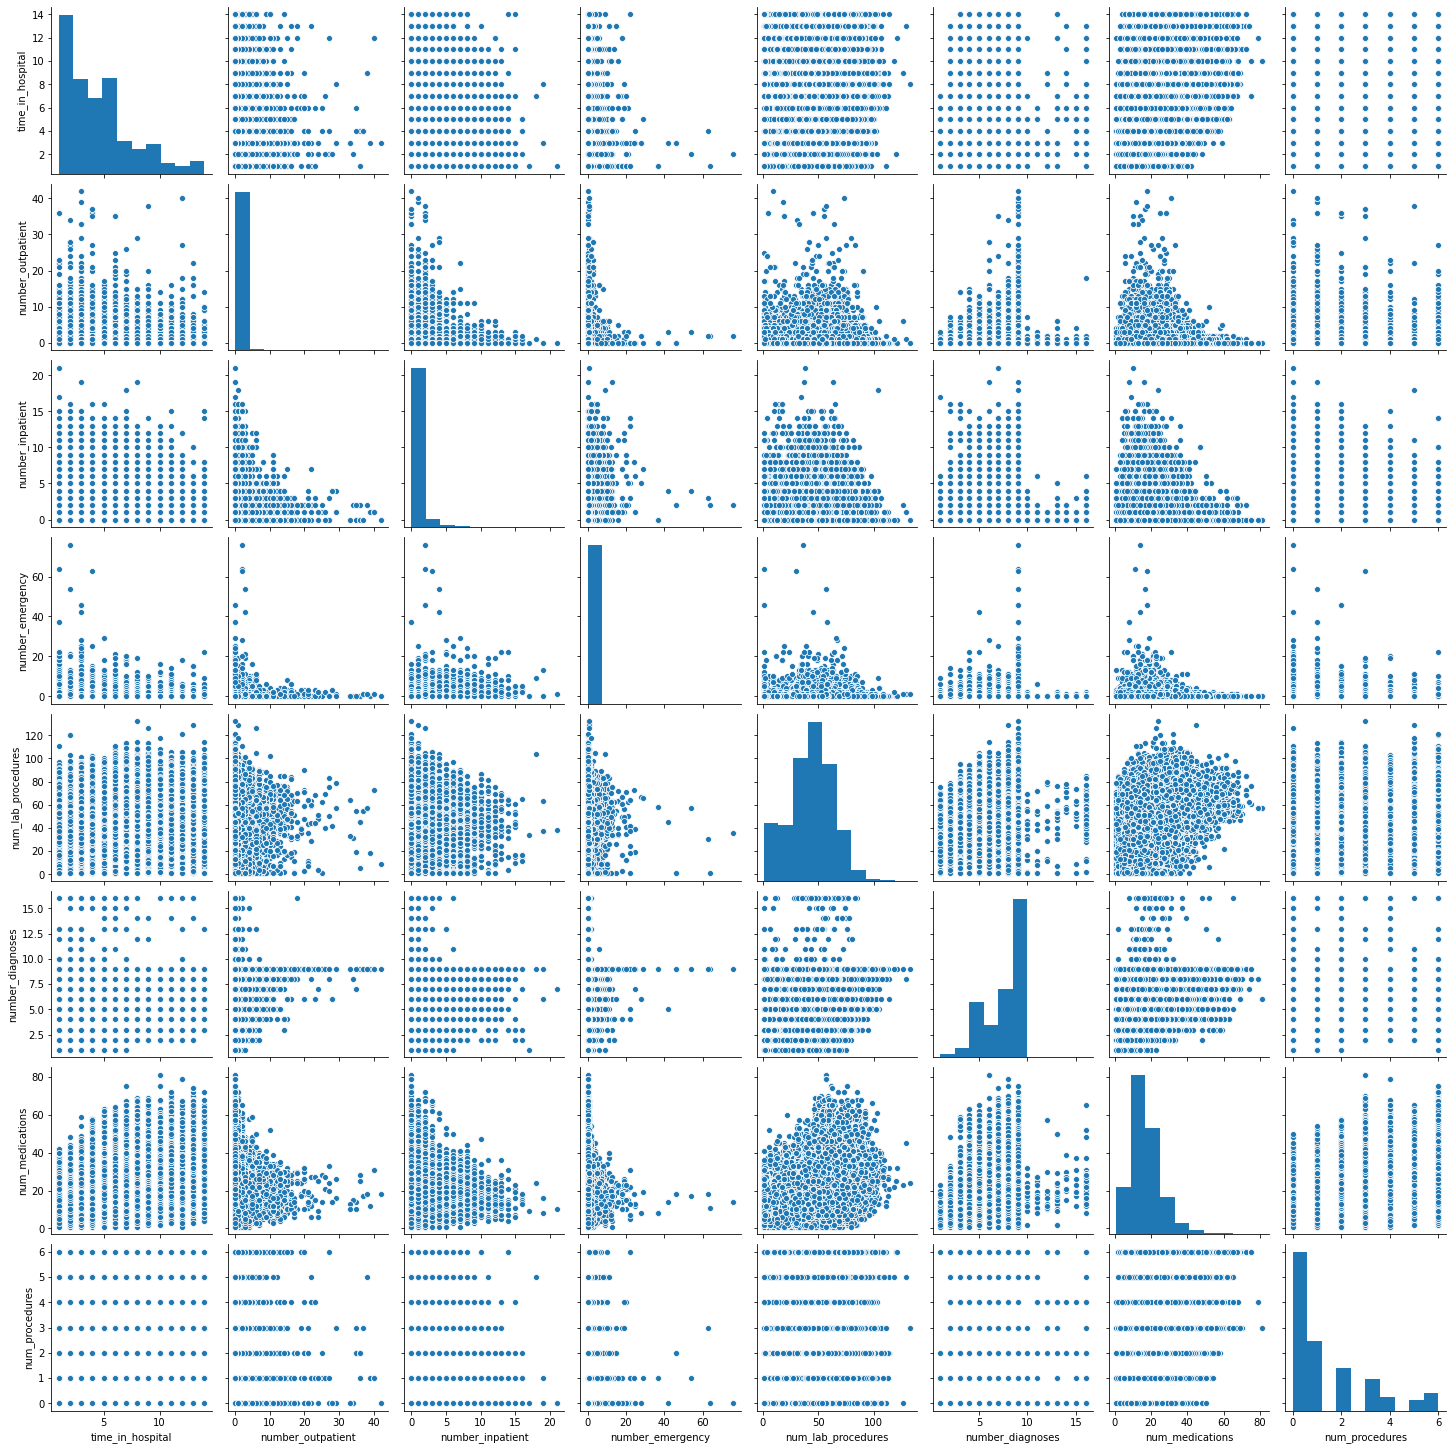

In [9]:
numerical = ['time_in_hospital', 
           'number_outpatient',
           'number_inpatient', 
           'number_emergency', 
           'num_lab_procedures',
           'number_diagnoses', 
           'num_medications', 
           'num_procedures']

# Takes a while to plot so I implemented this loading feature
generate = False

if generate:
    sns_plot = sns.pairplot(df2[numerical])
    sns_plot.savefig("numerical_hists.png")
else:
    from IPython.display import Image, display
    display(Image(filename='numerical_hists.png'))

### Which fields have normal distributions? num_medications and num_lab_procedures

In [10]:
df[numerical].describe()

time_in_hospital  number_outpatient  number_inpatient  \
count     143424.000000      143424.000000     143424.000000   
mean           4.490190           0.362429          0.600855   
std            2.999667           1.249295          1.207934   
min            1.000000           0.000000          0.000000   
25%            2.000000           0.000000          0.000000   
50%            4.000000           0.000000          0.000000   
75%            6.000000           0.000000          1.000000   
max           14.000000          42.000000         21.000000   

       number_emergency  num_lab_procedures  number_diagnoses  \
count     143424.000000       143424.000000     143424.000000   
mean           0.195086           43.255745          7.424434   
std            0.920410           19.657319          1.924872   
min            0.000000            1.000000          1.000000   
25%            0.000000           32.000000          6.000000   
50%            0.000000           44.000000          8.000000   
75%            0.000000           57.000000          9.000000   
max           76.000000          132.000000         16.000000   

       num_medications  num_procedures  
count    143424.000000   143424.000000  
mean         16.776035        1.349021  
std           8.397130        1.719104  
min           1.000000        0.000000  
25%          11.000000        0.000000  
50%          15.000000        1.000000  
75%          21.000000        2.000000  
max          81.000000        6.000000

In [11]:
categorical = list(df.select_dtypes(['object']).columns)
categorical.extend(['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
for col in categorical:
    ### Fixing issue where np.nan was being converted to a string
    df[col] = np.where(pd.isnull(df[col]), df[col], df[col].astype(str))

In [12]:
categorical_df = df[categorical]
cardinality = pd.DataFrame({'columns': categorical_df.columns, 'cardinality': categorical_df.nunique()})
cardinality.sort_values('cardinality', ascending=True)

columns  cardinality
change                                      change            2
gender                                      gender            3
max_glu_serum                        max_glu_serum            3
A1Cresult                                A1Cresult            3
readmitted                              readmitted            3
race                                          race            5
admission_type_id                admission_type_id            8
age                                            age           10
payer_code                              payer_code           17
admission_source_id            admission_source_id           17
discharge_disposition_id  discharge_disposition_id           26
medical_specialty                medical_specialty           72
ndc_code                                  ndc_code          251
primary_diagnosis_code      primary_diagnosis_code          716
other_diagnosis_codes        other_diagnosis_codes        19374

### ndc_code, primary_diagnosis_code, and other_diagnosis_code show high cardinalities

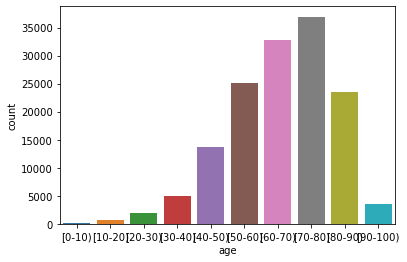

In [13]:
# Demographic distributions for age, race, and gender
plt.autoscale(enable=True)
sns.countplot(df['age'])

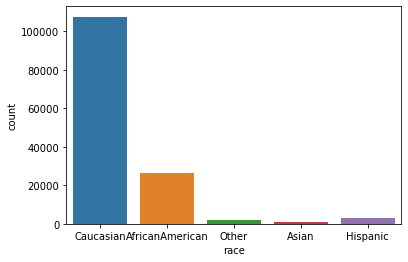

In [14]:
sns.countplot(df['race'])

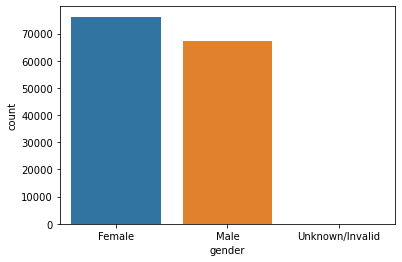

In [15]:
sns.countplot(df['gender'])

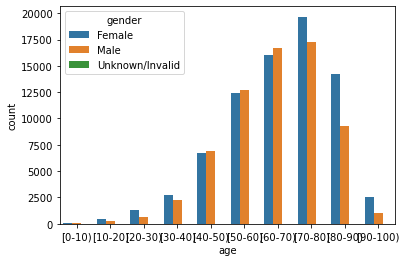

In [16]:
sns.countplot(df['age'], hue=df['gender'])

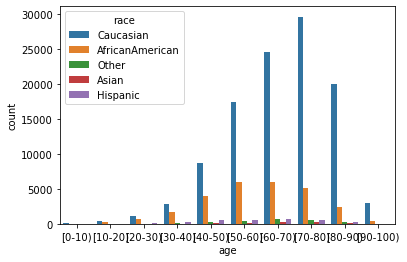

In [17]:
sns.countplot(df['age'], hue=df['race'])

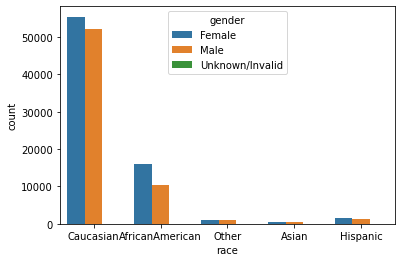

In [18]:
sns.countplot(df['race'], hue=df['gender'])

In [19]:
######## NOTE: The visualization will only display in Chrome browser. ########
######## full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
######## tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [20]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [21]:
from student_utils import reduce_dimension_ndc

In [22]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [23]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [24]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [25]:
first_encounter_df.head()

patient_nbr  encounter_id             race  gender      age  \
0          135      24437208        Caucasian  Female  [50-60)   
1          378      29758806        Caucasian  Female  [50-60)   
2          729     189899286        Caucasian  Female  [80-90)   
3          774      64331490        Caucasian  Female  [80-90)   
4          927      14824206  AfricanAmerican  Female  [30-40)   

  admission_type_id discharge_disposition_id admission_source_id  \
0                 2                        1                   1   
1                 3                        1                   1   
2                 1                        3                   7   
3                 1                        1                   7   
4                 1                        1                   7   

   time_in_hospital payer_code medical_specialty primary_diagnosis_code  \
0                 8        NaN        Cardiology                    401   
1                 2        NaN     Surgery-Neuro                    722   
2                 4         MC  InternalMedicine                    820   
3                 3        NaN  InternalMedicine                    274   
4                 5        NaN  InternalMedicine                    590   

  other_diagnosis_codes  number_outpatient  number_inpatient  \
0               997|560                  0                 0   
1               305|250                  0                 0   
2              493|E880                  0                 0   
3               427|416                  0                 0   
4               220|250                  0                 0   

   number_emergency  num_lab_procedures  number_diagnoses  num_medications  \
0                 0                  77                 8               33   
1                 0                  49                 3               11   
2                 0                  68                 9               23   
3                 0                  46                 9               20   
4                 0                  49                 3                5   

   num_procedures max_glu_serum A1Cresult change readmitted  \
0               6          Norm      Norm     Ch        <30   
1               1          Norm      Norm     No         NO   
2               2          Norm        >7     No         NO   
3               0          Norm        >8     Ch         NO   
4               0          Norm      Norm     No         NO   

         generic_drug_name  
0  Metformin Hydrochloride  
1                      NaN  
2  Metformin Hydrochloride  
3  Metformin Hydrochloride  
4              Glimepiride

In [26]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


In [27]:
first_encounter_df = first_encounter_df.replace(np.nan, "?")

## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [28]:
# agg_drug_df = first_encounter_df.copy()
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')
try:
    agg_drug_df = agg_drug_df.drop(columns=['?'])
except:
    pass
agg_drug_df

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


patient_nbr  encounter_id             race  gender      age  \
0              135      24437208        Caucasian  Female  [50-60)   
1              378      29758806        Caucasian  Female  [50-60)   
2              729     189899286        Caucasian  Female  [80-90)   
3              774      64331490        Caucasian  Female  [80-90)   
4              927      14824206  AfricanAmerican  Female  [30-40)   
...            ...           ...              ...     ...      ...   
71513    189351095     418513058        Caucasian  Female  [80-90)   
71514    189365864     359719064            Other    Male  [60-70)   
71515    189445127     338462954        Caucasian  Female  [80-90)   
71516    189481478     443811536        Caucasian  Female  [40-50)   
71517    189502619     371459060        Caucasian    Male  [40-50)   

      admission_type_id discharge_disposition_id admission_source_id  \
0                     2                        1                   1   
1                     3                        1                   1   
2                     1                        3                   7   
3                     1                        1                   7   
4                     1                        1                   7   
...                 ...                      ...                 ...   
71513                 1                        1                   7   
71514                 1                        1                   7   
71515                 1                        1                   7   
71516                 1                        4                   7   
71517                 2                        1                   1   

       time_in_hospital payer_code medical_specialty primary_diagnosis_code  \
0                     8          ?        Cardiology                    401   
1                     2          ?     Surgery-Neuro                    722   
2                     4         MC  InternalMedicine                    820   
3                     3          ?  InternalMedicine                    274   
4                     5          ?  InternalMedicine                    590   
...                 ...        ...               ...                    ...   
71513                 1          ?                 ?                    285   
71514                 3         HM  InternalMedicine                    584   
71515                 3          ?                 ?                    486   
71516                14         MD                 ?                    295   
71517                 5         HM                 ?                    553   

      other_diagnosis_codes  number_outpatient  number_inpatient  \
0                   997|560                  0                 0   
1                   305|250                  0                 0   
2                  493|E880                  0                 0   
3                   427|416                  0                 0   
4                   220|250                  0                 0   
...                     ...                ...               ...   
71513               401|496                  0                 0   
71514            250.02|403                  0                 0   
71515               414|733                  0                 0   
71516               305|250                  0                 0   
71517               518|V85                  0                 0   

       number_emergency  num_lab_procedures  number_diagnoses  \
0                     0                  77                 8   
1                     0                  49                 3   
2                     0                  68                 9   
3                     0                  46                 9   
4                     0                  49                 3   
...                 ...                 ...               ...   
71513                 0                  73                 9   
71514          

In [29]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: ??

### weight had a null percentage of 97%, so it will be left out.

In [30]:
required_demo_col_list = ['race', 'gender', 'age']
###"ndc_code",
try:
    ndc_col_list.remove['?']
except:
    pass
student_categorical_col_list = ["readmitted", 'admission_type_id', 'discharge_disposition_id', 'max_glu_serum', 'admission_source_id', 'A1Cresult', 'primary_diagnosis_code', 'other_diagnosis_codes', 'change'] + required_demo_col_list + ndc_col_list
student_numerical_col_list = [ "num_procedures", "num_medications", 'number_diagnoses']
PREDICTOR_FIELD = 'time_in_hospital'

In [31]:
try:
    student_categorical_col_list.remove('?')
except ValueError as e:
    print(e)
    pass

In [32]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list
    return agg_drug_df[selected_col_list]

In [33]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list, PREDICTOR_FIELD)
selected_features_df = selected_features_df.replace("?", np.nan)
selected_features_df = selected_features_df.T.drop_duplicates().T

In [34]:
selected_features_df

patient_nbr time_in_hospital readmitted admission_type_id  \
0             135                8        <30                 2   
1             378                2         NO                 3   
2             729                4         NO                 1   
3             774                3         NO                 1   
4             927                5         NO                 1   
...           ...              ...        ...               ...   
71513   189351095                1         NO                 1   
71514   189365864                3         NO                 1   
71515   189445127                3         NO                 1   
71516   189481478               14        >30                 1   
71517   189502619                5         NO                 2   

      discharge_disposition_id max_glu_serum admission_source_id A1Cresult  \
0                            1          Norm                   1      Norm   
1                            1          Norm                   1      Norm   
2                            3          Norm                   7        >7   
3                            1          Norm                   7        >8   
4                            1          Norm                   7      Norm   
...                        ...           ...                 ...       ...   
71513                        1          Norm                   7      Norm   
71514                        1          Norm                   7      Norm   
71515                        1          Norm                   7      Norm   
71516                        4          Norm                   7        >7   
71517                        1          Norm                   1      Norm   

      primary_diagnosis_code other_diagnosis_codes change             race  \
0                        401               997|560     Ch        Caucasian   
1                        722               305|250     No        Caucasian   
2                        820              493|E880     No        Caucasian   
3                        274               427|416     Ch        Caucasian   
4                        590               220|250     No  AfricanAmerican   
...                      ...                   ...    ...              ...   
71513                    285               401|496     No        Caucasian   
71514                    584            250.02|403     No            Other   
71515                    486               414|733     Ch        Caucasian   
71516                    295               305|250     Ch        Caucasian   
71517                    553               518|V85     Ch        Caucasian   

       gender      age Acarbose Glimepiride Glipizide  \
0      Female  [50-60)        0           0         0   
1      Female  [50-60)        0           0         0   
2      Female  [80-90)        0           0         0   
3      Female  [80-90)        0           0         0   
4      Female  [30-40)        0           1         0   
...       ...      ...      ...         ...       ...   
71513  Female  [80-90)        0           0         0   
71514    Male  [60-70)        0           0         0   
71515  Female  [80-90)        0           0         0   
71516  Female  [40-50)        0           0         0   
71517    Male  [40-50)        0           0         0   

      Glipizide_And_Metformin_Hydrochloride Glyburide  \
0                                         0         0   
1                                         0         0   
2                                         0         0   
3                                         0         0   
4                                         0         0   
...                                     ...       ...   
71513                                     0         0   
71514                                     0         0   
71515                                     0         0   
71516                                     0         0   
71517          

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

### Answer: imputing that missing numerical values should be zero can skew your data. E.g. if we imputed A1Cresult to be 0 when that patient's average A1Cresult is 7.5.
### An alternative is to impute with a rolling mean for the patient (if available) or else find a way for the model to handle nan values.

In [35]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

In [36]:
try:
    processed_df = processed_df.drop(columns=[''])
except KeyError as e:
    print(e)
    pass
sorted(list(processed_df.columns))

"[''] not found in axis"


['A1Cresult',
 'Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Human_Insulin',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide',
 'admission_source_id',
 'admission_type_id',
 'age',
 'change',
 'discharge_disposition_id',
 'gender',
 'max_glu_serum',
 'num_medications',
 'num_procedures',
 'number_diagnoses',
 'other_diagnosis_codes',
 'patient_nbr',
 'primary_diagnosis_code',
 'race',
 'readmitted',
 'time_in_hospital']

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [37]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [38]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [39]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     2139
2.0     2530
3.0     2495
4.0     1921
5.0     1391
6.0     1034
7.0      757
8.0      606
9.0      371
10.0     308
11.0     252
12.0     181
13.0     180
14.0     138
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


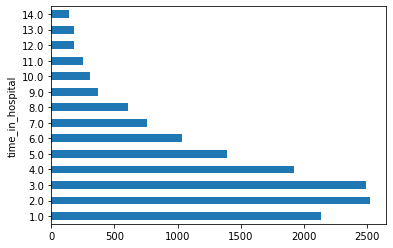

In [40]:
show_group_stats_viz(d_val, PREDICTOR_FIELD)

time_in_hospital
1.0     6476
2.0     7381
3.0     7667
4.0     5771
5.0     4079
6.0     3056
7.0     2432
8.0     1724
9.0     1234
10.0     929
11.0     727
12.0     565
13.0     465
14.0     404
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


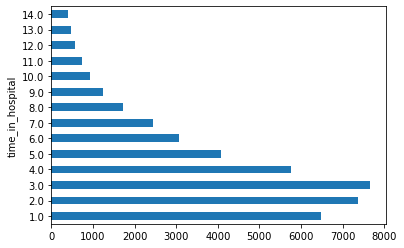

In [41]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2102
2.0     2486
3.0     2539
4.0     1875
5.0     1369
6.0     1081
7.0      810
8.0      589
9.0      385
10.0     321
11.0     262
12.0     209
13.0     150
14.0     127
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


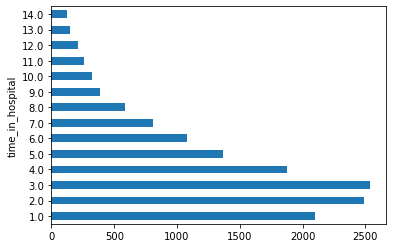

In [42]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             38025
Male               33490
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


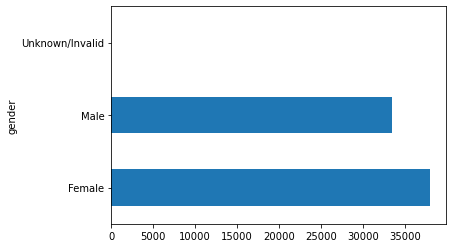

In [43]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             22811
Male               20096
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


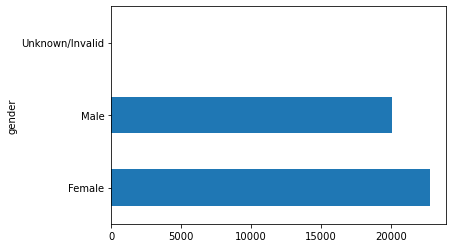

In [44]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    7567
Male      6738
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


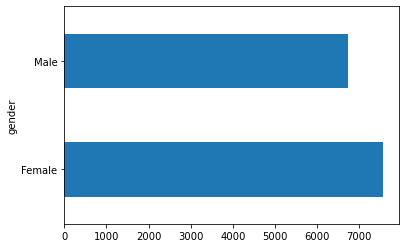

In [45]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [46]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
for col in student_categorical_col_list:
    d_train[col] = d_train[col].astype(str)
    d_val[col] = d_val[col].astype(str)
    d_test[col] = d_test[col].astype(str)
for col in student_numerical_col_list:
    d_train[col] = d_train[col].astype(float)
    d_val[col] = d_val[col].astype(float)
    d_test[col] = d_test[col].astype(float)

diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [47]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

In [48]:
### small batch size for printing out
demo_batch = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=5)

In [49]:
for feature_batch, label_batch in demo_batch.take(1):
    print('Every feature:', sorted(list(feature_batch.keys())))
    print('A batch of ages:', feature_batch['age'])
    print('A batch of targets:', label_batch )


Every feature: ['A1Cresult', 'Acarbose', 'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hydrochloride', 'Glyburide', 'Glyburide_And_Metformin_Hydrochloride', 'Human_Insulin', 'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide', 'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride', 'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide', 'admission_source_id', 'admission_type_id', 'age', 'change', 'discharge_disposition_id', 'gender', 'max_glu_serum', 'num_medications', 'num_procedures', 'number_diagnoses', 'other_diagnosis_codes', 'patient_nbr', 'primary_diagnosis_code', 'race', 'readmitted']
A batch of ages: tf.Tensor([b'[50-60)' b'[50-60)' b'[40-50)' b'[50-60)' b'[40-50)'], shape=(5,), dtype=string)
A batch of targets: tf.Tensor([8. 1. 6. 3. 2.], shape=(5,), dtype=float32)


# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [50]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [51]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.
INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 26 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in max_glu_serum is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/max_glu_serum_vocab.txt.
INFO:tensorflow:vocabulary_size = 18 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in A1Cresult is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/A1Cresult_vocab.txt.
INFO:tensorflow:vocabu

In [52]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='readmitted', vocabulary_file='./diabetes_vocab/readmitted_vocab.txt', vocabulary_size=4, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [53]:
from student_utils import create_tf_numeric_feature

In [54]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].astype(float).mean() #.describe()['mean']
    std = df[col].astype(float).std() #.describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [55]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [56]:
tf_cont_col_list

[NumericColumn(key='num_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f18db9b13b0>, mean=1.4382661384292705, std=1.7609468381598354)),
 NumericColumn(key='num_medications', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f18db9b13b0>, mean=15.681449545560476, std=8.244098047788741)),
 NumericColumn(key='number_diagnoses', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f18db9b13b0>, mean=7.243439757632253, std=1.9913410419719828))]

In [57]:
test_cont_var1 = tf_cont_col_list[1]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_medications', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f18db9b13b0>, mean=15.681449545560476, std=8.244098047788741))

tf.Tensor(
[[-1.0530504 ]
 [ 0.64513427]
 [-1.2956481 ]
 [ 0.03863978]
 [-1.5382459 ]
 [ 0.40253648]
 [-0.93175143]
 [-0.6891536 ]
 [ 0.15993868]
 [-0.8104525 ]
 [ 1.2516288 ]
 [-0.8104525 ]
 [ 0.40253648]
 [ 1.0090309 ]
 [ 0.64513427]
 [-0.93175143]
 [-0.5678547 ]
 [ 0.7664332 ]
 [-0.93175143]
 [-0.3252569 ]
 [ 0.03863978]
 [-0.3252569 ]
 [-0.8104525 ]
 [-0.08265913]
 [ 1.1303298 ]
 [ 1.1303298 ]
 [-1.6595448 ]
 [-0.44655582]
 [-1.1743492 ]
 [ 0.15993868]
 [-0.5678547 ]
 [-0.20395802]
 [-0.93175143]
 [ 0.03863978]
 [-0.3252569 ]
 [ 0.03863978]
 [ 0.52383536]
 [-0.93175143]
 [-1.6595448 ]
 [ 1.2516288 ]
 [ 1.7368244 ]
 [-1.2956481 ]
 [-0.6891536 ]
 [ 1.8581233 ]
 [-0.08265913]
 [-1.416947  ]
 [-0.44655582]
 [-1.7808437 ]
 [ 1.6155255 ]

In [58]:
tf_cont_col_list

[NumericColumn(key='num_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f18db9b13b0>, mean=1.4382661384292705, std=1.7609468381598354)),
 NumericColumn(key='num_medications', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f18db9b13b0>, mean=15.681449545560476, std=8.244098047788741)),
 NumericColumn(key='number_diagnoses', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f18db9b13b0>, mean=7.243439757632253, std=1.9913410419719828))]

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [59]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [60]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [61]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Train for 336 steps, validate for 112 steps
Epoch 1/10
336/336 [==============================] - 14s 41ms/step - loss: 25.4824 - mse: 25.2715 - val_loss: 18.4668 - val_mse: 18.0369
Epoch 2/10
336/336 [==============================] - 10s 31ms/step - loss: 16.2688 - mse: 15.5271 - val_loss: 13.2187 - val_mse: 12.4312
Epoch 3/10
336/336 [==============================] - 10s 30ms/step - loss: 13.2024 - mse: 12.3902 - val_loss: 11.6870 - val_mse: 10.8701
Epoch 4/10
336/336 [==============================] - 10s 30ms/step - loss: 11.1619 - mse: 10.0660 - val_loss: 10.4226 - val_mse: 9.6758
Epoch 5/10
336/336 [==============================] - 10s 30ms/step - loss: 10.0324 - mse: 9.0479 - val_loss: 10.3285 - val_mse: 9.5347
Epoch 6/10
336/336 [==============================] - 10s 30ms/step - loss: 9.5544 - mse: 8.5357 - val_loss: 9.5480 - val_mse: 8.8209
Epoch 7/10
336/336 [==============================] - 10s 30ms/step - loss: 9.2129 - mse: 8.3544 - val_loss: 9.0415 - val_mse: 8.1175
E

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [64]:
# feature_list = set(student_categorical_col_list + student_numerical_col_list)
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

ResourceExhaustedError: OOM when allocating tensor with shape[14305,1,11400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:OneHot] name: sequential/dense_features_2/other_diagnosis_codes_indicator/one_hot/

In [ ]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [ ]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [ ]:
prob_output_df.head()

## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [ ]:
from student_utils import get_student_binary_prediction
# student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean', 'actual_value', 5)
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean', 5)

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [ ]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
#     test_df.reset_index(inplace=True)
#     test_df = pd.concat([test_df, student_binary_prediction], axis=1)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [ ]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [ ]:
# AUC, F1, precision and recall
# Summary

In [ ]:
y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values
print('accuracy_score:', accuracy_score(y_true, y_pred))
print()
print('f1_score:', f1_score(y_true, y_pred))
print()
print('classification_report:')
print(classification_report(y_true, y_pred))
print()
print('roc_auc_score:', roc_auc_score(y_true, y_pred))

In [ ]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Patient Selection for Diabetes Drug', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
plot_auc(y_true, y_pred)

In [ ]:
# shifting the decision boundary can either increase the precision or recall but not both
# in other words, increasing one parameter leads to decreasing of the other
# F1 score is a weighted average of precision and recall and helps to balance the two

def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Patient Selection for Diabetes Drug', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Precision')
    c_ax.set_ylabel('Recall')
    
plot_pr(y_true, y_pred)

## "What are some areas of improvement for future iterations?"

### We could improve the features by conducting a principal component analysis to reduce dimensionality. We could alter the model by adding layers to see if the model improves.

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [ ]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [ ]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [ ]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

In [ ]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race')

### African Americans are more likely to have a false positive

In [ ]:
fpr_dispary = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='gender')

### Females are more likely to have a false positive

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

In [ ]:
# Reference group fairness plot
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

In [ ]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)